In [100]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
import numpy as np
from typing import Optional

REFERENCE_POINT = {'N': 7536302.173999999649823, 'E': 651364.265000000013970}

def get_data(file: str, 
             remove_rows: list) -> pd.DataFrame:
    theodelite = pd.read_excel(file)
    for row in remove_rows:
        theodelite.drop(row, inplace=True)
    return theodelite

def make_float(x: str) -> float:
    x = str(x)
    x = x.replace(',', '.')
    return float(x)

def get_data_from_DGPS(file: str, 
                       x_cord: str, 
                       y_cord: str, 
                       z_cord: str, 
                       year: int, 
                       sep: str=';',
                       remove_rows: Optional[list] = None) -> pd.DataFrame:
    theodelite_raw = pd.read_csv(file, sep=sep)
    theodelite = pd.DataFrame()
    theodelite['vd'] = theodelite_raw[z_cord].apply(make_float)
    theodelite['year'] = year
    north = (theodelite_raw[x_cord].apply(make_float) - REFERENCE_POINT['N']) * 111.139
    east = (theodelite_raw[y_cord].apply(make_float) - REFERENCE_POINT['E']) * 111.139
    dist = np.sqrt(north**2+east**2) / 10**2
    #theodelite['hd'] = east
    theodelite['hd'] = dist
    if remove_rows:
        for row in remove_rows:
            theodelite.drop(row, inplace=True) 
    return theodelite

def scatter_plot(theodelite: pd.DataFrame, 
                 title: str) -> None:
    plt.scatter(theodelite.hd, theodelite.vd)
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Vertical distance (m)')
    plt.title(title)
    plt.show()

def interpolation_plot(theodelite: pd.DataFrame, 
                       title: str) -> interp1d:
    f = interp1d(theodelite.hd, theodelite.vd)
    plt.plot(theodelite.hd, f(theodelite.hd))
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Vertical distance (m)')
    plt.title(title)
    plt.show()
    return f
    
def linreg_plot_and_corr(theodelite: pd.DataFrame, title: str) -> tuple[int]:
    t1000less = theodelite[theodelite.hd < 1000]
    t1000high = theodelite[theodelite.hd > 1000]

    f1 = linregress(t1000less.hd, t1000less.vd)
    f2 = linregress(t1000high.hd, t1000high.vd)
    f_all = linregress(theodelite.hd, theodelite.vd)
    plt.plot(t1000less.hd, f1.intercept + f1.slope*t1000less.hd, 
             t1000high.hd, f1.intercept + f1.slope*t1000high.hd, '--', 
             color = 'olive', label = 'Below riegel')
    plt.plot(t1000high.hd, f2.intercept + f2.slope*t1000high.hd, 
             t1000less.hd, f2.intercept + f2.slope*t1000less.hd, '--', 
             color = 'lightblue', label = 'Above riegel')
    plt.xlabel('Horizontal distance (m)')
    plt.ylabel('Vertical distance (m)')
    plt.title('Center line profile Storglaciären (linear regression)')
    plt.legend()
    plt.show()
    corr_front = f1.rvalue**2
    corr_back = f2.rvalue**2
    corr_all = f_all.rvalue**2
    print(f'Correlation below riegel: {corr_front:.4f}. Correlation above riegel: {corr_back:.4f}.')
    print(f'Correlation all profile: {corr_all:.4f}.')
    return corr_front, corr_back, corr_all

def call_all(data: pd.DataFrame, year: int) -> None:
    scatter_plot(data, title=f'Scatter Storglaciären elevation, {year}')
    interpolation_plot(data, title=f'Interpolation Storglaciären elevation, {year}')
    
def combine_theodolite_measurments_plot(base_x, *args):
    for theo in args:
        plt.scatter(theo.hd, theo.vd, label=theo.year[0])
    plt.ylabel('m a.s.l.')
    plt.xlabel('Horizontal distance (2019 reference stone, m)')
    plt.title('Storglaciären central line profile')
    plt.legend()
    plt.show()
    
    for theo in args:
        f = interp1d(theo.hd, theo.vd)
        plt.plot(base_x, f(base_x), label=theo.year[0])
    plt.ylabel('m a.s.l.')
    plt.xlabel('Horizontal distance (2019 reference stone, m)')
    plt.title('Storglaciären central line profile (interpolation)')
    plt.legend()
    plt.show()

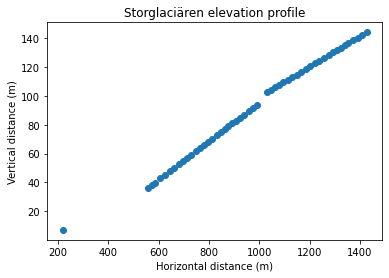

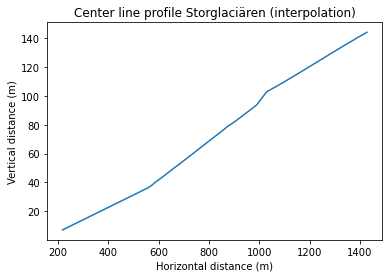

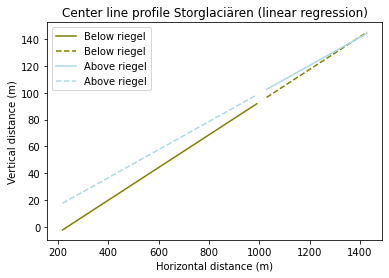

Correlation below riegel: 0.9865. Correlation above riegel: 0.9999.
Correlation all profile: 0.9948.


In [101]:
theodelite22 = get_data('theodelite.xlsx', [9, 29, 31])
scatter_plot(theodelite22, 'Storglaciären elevation profile')
interpolation_plot(theodelite22, 'Center line profile Storglaciären (interpolation)')
corrs = linreg_plot_and_corr(theodelite22, 'Linear correlation 2022')

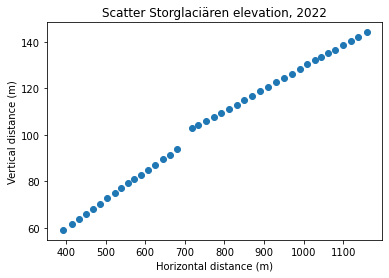

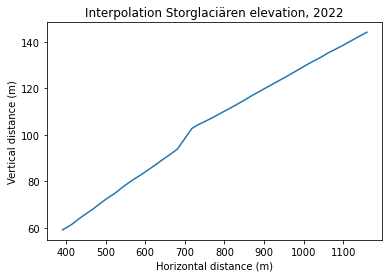

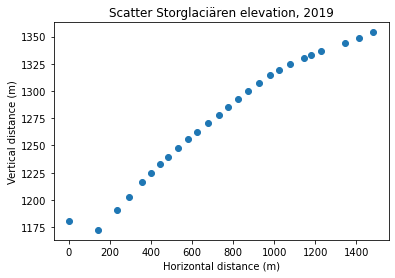

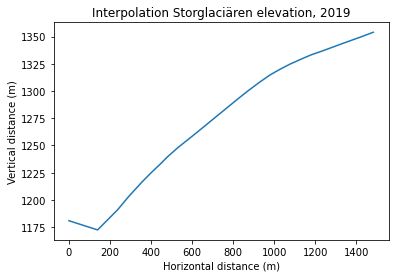

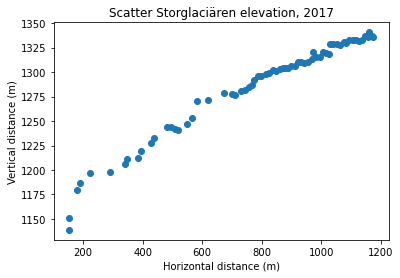

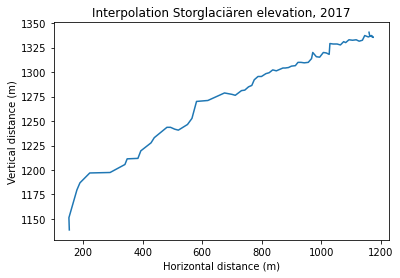

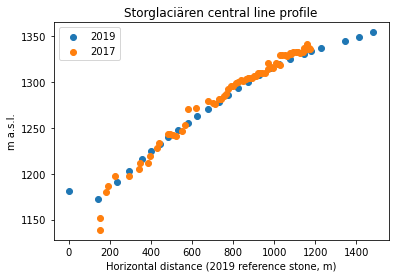

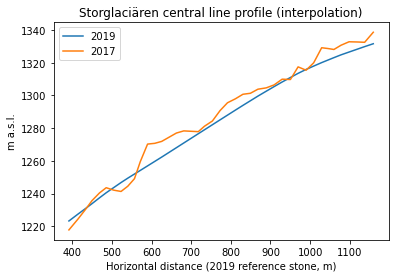

In [102]:
theodelite22 = get_data_from_DGPS('theodelite_2022.csv', 'Y', 'X', 'vd', year='2022', sep=',', remove_rows = [0])
call_all(theodelite22, 2022)

theodelite19 = get_data_from_DGPS('2019_DGPS_profile.txt', 'Northing', 'Easting', 'MSL', year='2019')
call_all(theodelite19, 2019)

theodelite17 = get_data_from_DGPS('2017_DGPS_profile.txt', 'Y', 'X', 'Elevation', year='2017')
call_all(theodelite17, 2017)

combine_theodolite_measurments_plot(theodelite22.hd, theodelite19,theodelite17)